#### Goal
What is a fair map for Black and Latino voters?

* Do district lines dilute votes of minority voters (e.g. via cracking/packing)?

* Where should additional 2 congressional districts be placed in Texas for fair representation of minorities?



#### Background

Texas has experienced a 15.3% population growth from 2010-2019, resulting in an addition of 2 new CD being alloted to Texas. This growth has been largely driven by growing minority populations. 

VRA Section 2 prohibits redistricting plan that abridges any citizen's right to vote "on account of race or color (or membership in a language-minority group)." Minority groups can assess whether a map violates VRA by evaluating  whether members of the minority group have "less opportuntity than other members of the electirate to nominate and elect representatives of their choice."

Historical information from recent elections can be used in assessment BUT VRA does not require that protected class must be elected in numbers proportionate to electorate demographics. However, in states where party affiliation overlaps with racial group identities, Section 2 does require districts be designed to allow minority groups to elect their preferred candidate, not just the candidate preferred by the majority (usually White) within the party. Thus, VRA stipulates the right to replace districts where minority-preferred candidates lose with districts where candidates are given the opportunity to win if they "pull, haul, and trade to find common ground" (Johnson v De Grandy, 1994).

Moon et al considers a district to be 'effective' for minority groups if the districts nominate (primary) and elect (generals) minority-preferred candidates (based on plurality/coalitions). Demographic targets are not explicitly considered a priori to avoid FP/FNs.

#### Demographic Changes:


https://demographics.texas.gov/Resources/Presentations/OSD/2021/2021_01_15_LeadershipNorthTexas.pdf
    
254 counties in Texas: 

* "Texas Triangle - Dallas FW, San Antonio, Houson, College Station, Austin" - 75% population

* 104 lost population from 2010-2019

Dallas -> Dallas County [County ID = 113] 
* (portions extending into Collin (085), Denton(121), Kaufman (257), & Rockwall(397) counties)
* 19% growth (+1.2M)

Houston -> Harris County [County ID = 201]
* 9.4% growth (+1.1M)

Austin -> Travis County [County ID = 453] 
* (portions extending into Hays (209) & Williamson (491) counties)
* 29.8% growth  (+0.5M)

In [16]:
import sys
import os

from functools import partial
import matplotlib.pyplot as plt
import random

import geopandas as gpd
import pandas as pd
import numpy as np

from gerrychain import (
    Election,
    Graph,
    MarkovChain,
    Partition,
    accept,
    constraints,
    updaters,
)

from gerrychain.metrics import efficiency_gap, mean_median
from gerrychain.proposals import recom, propose_random_flip
from gerrychain.updaters import cut_edges
from gerrychain.tree import recursive_tree_part, bipartition_tree_random
import maup

import networkx as nx

sys.path.insert(0, '/Users/rowanaahmed/Documents/DSSG/dssg2021-redistricting/')
import utility_functions

import warnings 
warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)

#### Read & Visualize Data

In [11]:
df = gpd.read_file("Data/TX_VTDs_POP2019/texas_population2019.shp")
graph = Graph.from_file("Data/TX_VTDs_POP2019/texas_population2019.shp")

prec_counts = pd.read_csv('Data/mean_prec_vote_counts.csv')


/Users/rowanaahmed/opt/anaconda3/envs/gerry_chain/lib/python3.9/site-packages/gerrychain/graph/adjacency.py:66: UserWarning: Found overlaps among the given polygons. Indices of overlaps: {(1165, 1170), (7889, 8135), (603, 762), (638, 695), (6531, 6548), (6573, 6618), (7539, 7582), (763, 1812), (3500, 3510), (499, 735), (6519, 6537), (5970, 8790), (628, 629), (3871, 3886), (5974, 8790), (1159, 1168), (2981, 8790), (1806, 3877), (1114, 1154), (612, 733), (445, 446), (873, 982), (605, 639), (3496, 3505), (1663, 1686), (824, 860), (1163, 1165), (2930, 2938), (657, 658), (904, 978), (1478, 1479), (2801, 2818), (6551, 6580), (1478, 1488), (1577, 1683), (2875, 2904), (2811, 2813), (2805, 2827), (1661, 1728), (2876, 2878), (5414, 6142), (8780, 8792), (656, 714), (7457, 7526), (3505, 3510), (324, 387), (1761, 1769), (1636, 1671), (322, 344), (2984, 8790), (4608, 6563), (2817, 2828), (6539, 6608), (6591, 6609), (2778, 2818), (3544, 3550), (8743, 8748), (572, 5833), (595, 758), (362, 6405), (1113

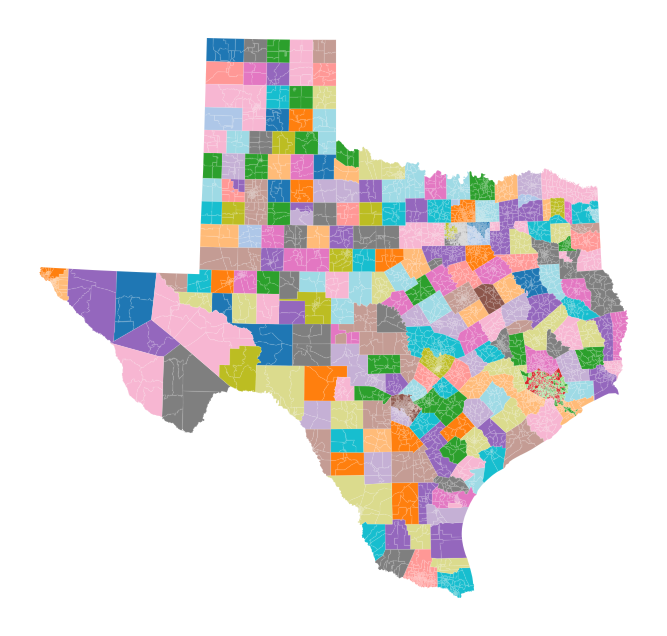

In [12]:
utility_functions.plot_district_map(df, df['CNTYVTD'].to_dict())

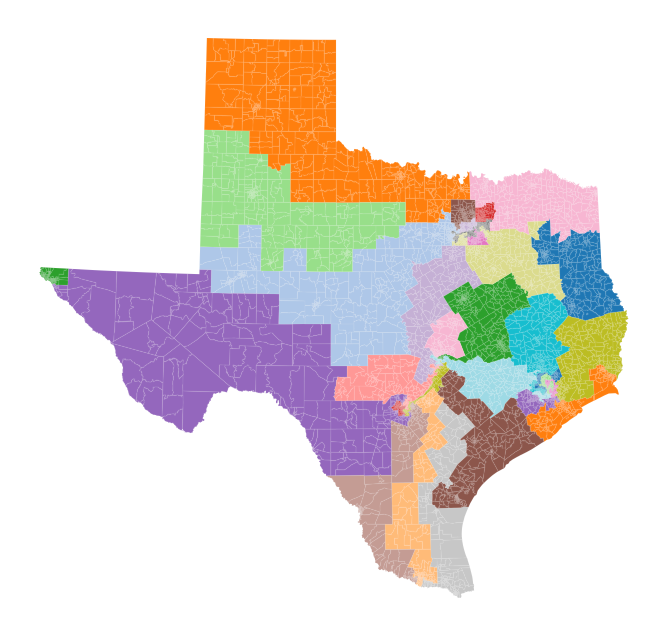

In [13]:
utility_functions.plot_district_map(df, df['CD'].to_dict())

In [14]:
df.columns.values

array(['CNTY_x', 'COLOR_x', 'VTD_x', 'CNTYVTD', 'VTDKEY_x', 'Shape_area',
       'Shape_len_', 'Unnamed_ 0', 'TOTPOP_x', 'NH_WHITE', 'NH_BLACK',
       'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'HISP',
       'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER',
       'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP',
       'NHPIVAP', 'OTHERVAP', '2MOREVAP', 'white_prop', 'black_prop',
       'hisp_prop', 'CD', 'Unnamed__1', 'RomneyR_12', 'ObamaD_12G',
       'JohnsonL_1', 'SteinG_12G', 'Write-In _', 'CruzR_12G_',
       'SadlerD_12', 'MyersL_12G', 'CollinsG_1', 'AllenD_12P',
       'HubbardD_1', 'SadlerD__1', 'YarbroughD', 'BachmannR_',
       'DavisR_12P', 'GingrichR_', 'HuntsmanR_', 'PaulR_12P_',
       'RoemerR_12', 'RomneyR__1', 'SantorumR_', 'Uncommitte',
       'AddisonR_1', 'AgrisR_12P', 'CleaverR_1', 'CruzR_12P_',
       'DewhurstR_', 'GambiniR_1', 'JamesR_12P', 'LeppertR_1',
       'PittengerR', 'SadlerD__2', 'Yarbroug_1', 'CruzR_12R_